In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import sklearn
random_state = 100
warnings.filterwarnings('ignore')

# Preprocesing #

In [121]:
sklearn.__version__

'0.24.1'

In [2]:
# Leemos los datos
data = pd.read_csv('BDpracticafinal.csv')
data.columns = data.columns.str.replace(" ","_")
# Escojemos solo las zona residenciales bajas, medias y altas
data = data[data.MS_Zoning.isin(['RH','RL','RM'])]

# Rellenamos valores missing
data['Lot_Frontage'] = data['Lot_Frontage'].fillna(0)
data['Mas_Vnr_Type']= data['Mas_Vnr_Type'].fillna('None')
data['Garage_Cars']= data['Garage_Cars'].fillna(0)
data['Garage_Area']= data['Garage_Area'].fillna(0)
data['Garage_Cond']= data['Garage_Cond'].fillna('Sg')
data = data.drop(columns='Order')

In [3]:
pendiente = {'Gtl':0, 'Mod':1, 'Sev':2}
calidad_sotano = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Ss':0}
calidad_garage = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Sg':0}
calidad_piscina = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'Sp':0}
calidad_general = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
quality_columns = ['Exter_Qual', 'Heating_QC', 'Kitchen_Qual']

data[quality_columns] = data[quality_columns].replace(calidad_general)
data['Land_Slope'] = data['Land_Slope'].replace(pendiente)
data['Bsmt_Cond'] = data['Bsmt_Cond'].replace(calidad_sotano)
data['Garage_Cond'] = data['Garage_Cond'].replace(calidad_garage)
data['Pool_QC'] = data['Pool_QC'].replace(calidad_piscina)
data = pd.get_dummies(data)

# Split data in train and test #

In [4]:
data_train, data_test = train_test_split(data, test_size = 0.3, random_state = random_state)

In [5]:
from sklearn.pipeline import Pipeline

# Regresion lineal #

In [6]:
scaler = StandardScaler()
train_scaler = scaler.fit(data_train)

# - después normalizamos el conjunto de datos que queramos con dichos parámetros. Es necesario crear un dataframe nuevo ya que estos métodos
# devuelven un array numpy
data_train_norm = pd.DataFrame(index=data_train.index, columns=data_train.columns, data=train_scaler.transform(data_train))

## Entrenamiento ##

In [7]:
X = data_train_norm.drop(columns='SalePrice')
y = data_train_norm['SalePrice']

In [8]:
lr = LinearRegression(normalize=False)

In [9]:
lr.fit(X,y)

LinearRegression()

In [10]:
lr.score(X,y)

0.798926849623524

## Evaluación ##

In [11]:
data_test_norm = pd.DataFrame(index=data_test.index,  columns=data_test.columns, data=train_scaler.transform(data_test))
Xtest = data_test_norm.drop(columns='SalePrice')
ytest = data_test_norm['SalePrice']

In [12]:
predictions = lr.predict(Xtest)

In [13]:
R_2 = lr.score(Xtest,ytest)
R_2

0.8201340699495896

In [14]:
predicted_data_norm = data_test_norm.copy()
predicted_data_norm['SalePrice'] = predictions

In [15]:
predicted_data_unorm = pd.DataFrame(index=predicted_data_norm.index, columns=predicted_data_norm.columns, data=train_scaler.inverse_transform(predicted_data_norm))

In [16]:
predicted_data_unorm['predicted_sale'] = predicted_data_unorm['SalePrice']
predicted_data_unorm['SalePrice'] = data_test['SalePrice']

In [17]:
predicted_data_unorm[['SalePrice','predicted_sale']].head(3)

,SalePrice,predicted_sale
1490,135000,157785.485944
2156,131500,144461.366973
2530,140000,188915.472993


In [18]:
rmse_linear = np.sqrt(((predicted_data_unorm['SalePrice'] - predicted_data_unorm['predicted_sale'])**2).mean())

In [19]:
rmse_linear

32336.181782678737

In [20]:
mean_squared_error(predicted_data_unorm['SalePrice'], predicted_data_unorm['predicted_sale'], squared=False)

32336.181782678726

# knn regresor #

In [21]:
from sklearn.neighbors import KNeighborsRegressor

## Entrenamiento ##

In [22]:
knn = KNeighborsRegressor(3)

In [23]:
knn.fit(X,y)

KNeighborsRegressor(n_neighbors=3)

In [24]:
knn.score(X,y)

0.8956342387502025

## Evaluación ##

In [25]:
knn.score(Xtest,ytest)

0.7889989827497312

In [26]:
knn.predict(Xtest)[0]

-0.2648968113561081

In [27]:
knn_data_norm = data_test_norm.copy()
knn_data_norm['SalePrice'] = knn.predict(Xtest)

In [28]:
knn_data_unorm = pd.DataFrame(index=knn_data_norm.index, columns=knn_data_norm.columns, data=train_scaler.inverse_transform(knn_data_norm))

In [29]:
knn_data_unorm['predicted_sale'] = knn_data_unorm['SalePrice']
knn_data_unorm['SalePrice'] =data_test['SalePrice']

In [30]:
knn_data_unorm[['SalePrice','predicted_sale']].head(4)

,SalePrice,predicted_sale
1490,135000,158833.333333
2156,131500,144933.333333
2530,140000,162166.666667
1599,98000,107969.666667


In [31]:
rmse_knn = np.sqrt(((knn_data_unorm['SalePrice'] - knn_data_unorm['predicted_sale'])**2).mean())

In [32]:
rmse_knn

35023.25920359679

# Decision Trees #

In [33]:
from sklearn.tree import DecisionTreeRegressor

In [34]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=6)

## Entrenamiento ## 

In [35]:
X = data_train.drop(columns='SalePrice')
y = data_train['SalePrice']

In [36]:
regressor.fit(X,y)

DecisionTreeRegressor(max_depth=6, random_state=0)

In [37]:
regressor.score(X,y)

0.8786743854909749

## Evaluación ##

In [38]:
X_test = data_test.drop(columns='SalePrice')
y_test = data_test['SalePrice']

In [39]:
regressor.score(X_test,y_test)

0.7764820138288161

In [40]:
data_eval = data_test.copy()
data_eval['sales_predicted'] =  regressor.predict(Xtest)
rmse_tree = np.sqrt(((data_eval['SalePrice'] - data_eval['sales_predicted'])**2).mean())
rmse_tree

127052.77797319643

# Resumen métodos anteriores #

In [41]:
print(f"lineal regresor {round(rmse_linear,2)}")
print(f"knn regresor {round(rmse_knn,2)}")
print(f"tree regresor {round(rmse_tree,2)}")

lineal regresor 32336.18
knn regresor 35023.26
tree regresor 127052.78


In [42]:
from  sklearn.ensemble import BaggingRegressor

In [43]:
bagging = BaggingRegressor(n_estimators=50)

In [44]:
X_bagging = data_train.drop(columns='SalePrice')
y_bagging = data_train['SalePrice']

In [45]:
bagging.fit(X_bagging, y_bagging)

BaggingRegressor(n_estimators=50)

In [46]:
bagging.score(X_bagging, y_bagging)

0.9794527829164206

In [47]:
X_baggin_test = data_test.drop(columns='SalePrice')
y_bagging_test = data_test['SalePrice']

In [48]:
bagging.score(X_baggin_test, y_bagging_test)

0.8559230956371259

In [49]:
rmse_bagging = mean_squared_error(y_bagging_test, bagging.predict(X_baggin_test), squared=False)
rmse_bagging

28940.862381853276

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
forest = RandomForestRegressor()

In [52]:
X_forest = data_train.drop(columns='SalePrice')
y_forest = data_train['SalePrice']

In [53]:
forest.fit(X_forest, y_forest)

RandomForestRegressor()

In [54]:
forest.score(X_forest,y_forest)

0.9816140915234113

In [55]:
X_forest_test = data_test.drop(columns='SalePrice')
y_forest_test = data_test['SalePrice']

In [56]:
forest.score(X_forest_test,y_forest_test)

0.8539326265372262

In [57]:
rmse_forest = mean_squared_error(y_forest_test, forest.predict(X_forest_test), squared=False)
rmse_forest

29140.09033631385

In [58]:
type(X_forest_test.iloc[0:1,:])

pandas.core.frame.DataFrame

In [59]:
forest.estimators_[0].predict(X_forest_test.iloc[0:1,:])

array([149500.])

In [60]:
estimations = [estimator.predict(X_forest_test.iloc[0:1,:]) for estimator in forest.estimators_]

In [125]:
import numpy as np
np.percentile(estimations,95)

175204.99999999997

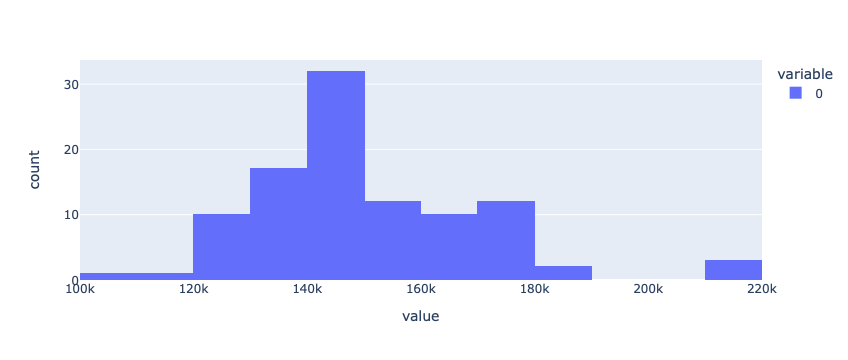

In [126]:
import plotly.express as px

fig = px.histogram(estimations)
fig.show()

In [127]:
X_boost = data_train.drop(columns='SalePrice')
y_boost = data_train['SalePrice']
X_test_boost = data_test.drop(columns='SalePrice')
y_test_boost = data_test['SalePrice']

In [128]:
from sklearn.ensemble import GradientBoostingRegressor

In [66]:
boost = GradientBoostingRegressor()
boost.fit(X_boost, y_boost)
boost.score(X_boost, y_boost)

0.937317796933012

In [129]:
boost.score(X_test_boost, y_test_boost)

0.8746991469750786

In [130]:
rmse_gboost = mean_squared_error(y_test_boost, boost.predict(X_test_boost), squared=False)

In [131]:
rmse_gboost

26989.279916697367

In [132]:
boost.feature_importances_

array([1.70346699e-03, 4.08599586e-02, 2.50221002e-03, 5.44793436e-01,
       7.86348371e-03, 2.15243594e-02, 6.80106098e-03, 8.84790413e-04,
       1.14053475e-01, 1.20129190e-03, 4.51960809e-02, 1.56163037e-02,
       7.34426102e-03, 1.53240145e-03, 3.22384611e-02, 1.75559419e-02,
       9.66791642e-02, 1.88217391e-02, 2.06215240e-03, 5.54052790e-04,
       2.69669276e-03, 2.09913131e-03, 3.76279877e-04, 2.57282640e-05,
       3.75044603e-03, 3.19148448e-04, 3.51921457e-03, 9.74014009e-04,
       0.00000000e+00, 1.79175183e-04, 5.34690825e-05, 1.06732435e-04,
       1.27714901e-04, 1.72096425e-04, 7.02007424e-04, 1.00462704e-03,
       4.10543157e-03])

In [71]:
features = [(a,b) for a,b in zip(X_boost.columns, boost.feature_importances_)]

In [72]:
features = sorted(features, key= lambda c:c[1], reverse=True)

In [133]:
len(features)

37

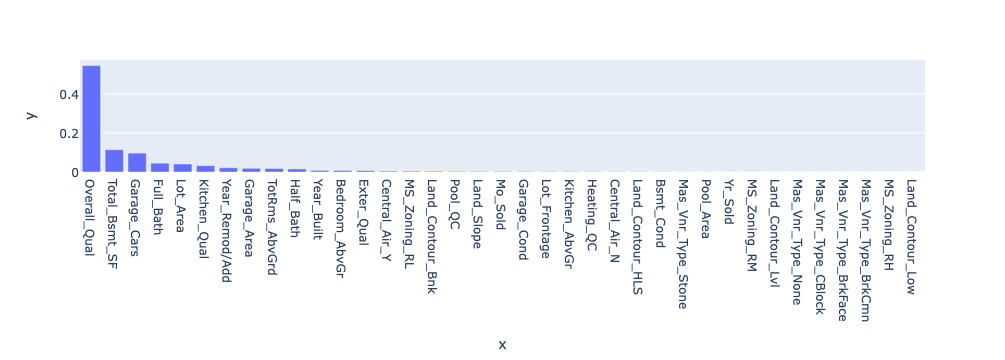

In [73]:
import plotly.express as px
fig = px.bar(x=[a for a,b in features], y=[b for a,b in features])
fig.show()

In [74]:
#install xgboost
# pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org xgboost
# brew install libomp
import xgboost as xgb

In [114]:
reg = xgb.XGBRegressor(n_estimators=60, objective='reg:squarederror')

In [115]:
reg.fit(X_boost, y_boost)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=60, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [116]:
reg.score(X_boost, y_boost)

0.9929528539278462

In [117]:
reg.score(X_test_boost, y_test_boost)

0.8244391154722861

In [118]:
rmse_xgboost = mean_squared_error(y_test_boost, reg.predict(X_test_boost), squared=False)
rmse_xgboost

31946.858923447995